In [1]:
# import plotly.io as pio
# pio.orca.status

In [2]:
# %%time
# import plotly.io as pio
# from IPython.display import SVG, display
# img_bytes = pio.to_image(fig, format="svg")
# display(SVG(img_bytes))

In [3]:
# import plotly.io as pio
# from IPython.display import Image, display
# img_bytes = pio.to_image(fig, format="png")
# display(Image(img_bytes))

In [4]:
#! pip install pmdarima

# OUTLINE:
GETTING DATA  
EDA (TREND, SEASONALITY) -> the Dickey–Fuller test-> STATIONARITY  
DATA ENGINEERING, PREPROCESING  
MODELING (ARIMA)  
FORECAST, ERRORS

In [5]:
%matplotlib inline

In [6]:
# import libraries
# general:
import pickle
import numpy as np
import pandas as pd
import itertools
from math import ceil
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# models:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima.arima import auto_arima

# metrics:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


TIME SERIES:

univariate TS is a sequence of measurments of the SAME variable collected over time

data in TS not necessarly independent and not necessarly identically distributed

the ordering matters

***
***
# PART_1
***
***

GETTING DATA FROM IMF

https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/USA/WEOWORLD

IMF DATA MAPPER:  
https://www.imf.org/external/datamapper/datasets

DATASETS:  
https://www.imf.org/external/pubs/ft/weo/2019/01/weodata/index.aspx


In [7]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/world_data.xls', sep= '\t', index_col= 0, header= None)

In [8]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'WORLD_GROWTH', 'WORLD_GDP']

# chage data type from string --> float
data.WORLD_GDP= data.WORLD_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [9]:
# split data on actual and predicted
data_train= data.iloc[:-6, :]
data_test= data.iloc[-6:, :]

In [10]:
# create separate series
world_growth_train= data_train.WORLD_GROWTH
world_gdp_train= data_train.WORLD_GDP

In [11]:
# save every series as a pickle fle
with open ('world_growth_train.pickle', 'wb') as file:
    pickle.dump(world_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('world_gdp_train.pickle', 'wb') as file:
    pickle.dump(world_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [12]:
# def get_clean (file_name):
#     data= pd.read_csv(file_name, sep= '\t', index_col= 0, header= None)

REPEAT FOR US

In [13]:
# import data about world GDP and GDP GROWTH
data= pd.read_csv('data/us_data.xls', sep= '\t', index_col= 0, header= None)

In [14]:
# transpose and delete columns
data = data.T.iloc[4:-1, 0:3]

# rename columns
data.columns= ['YEAR', 'US_GROWTH', 'US_GDP']

# chage data type from string --> float
data.US_GDP= data.US_GDP.str.replace(',', '')
data= data.astype('float')

# change data type to datetime and set new index
data['YEAR']= pd.to_datetime(data.YEAR, format= '%Y')
data.set_index(data['YEAR'], drop= True, inplace= True)
data= data.drop(['YEAR'], axis= 1)

In [15]:
# split data on actual and predicted
dataUS_train= data.iloc[:-6, :]
dataUS_test= data.iloc[-6:, :]

# create separate series
us_growth_train= dataUS_train.US_GROWTH
us_gdp_train= dataUS_train.US_GDP

# save every series as a pickle fle
with open ('us_growth_train.pickle', 'wb') as file:
    pickle.dump(us_growth_train, file, pickle.HIGHEST_PROTOCOL)
    
with open ('us_gdp_train.pickle', 'wb') as file:
    pickle.dump(us_gdp_train, file, pickle.HIGHEST_PROTOCOL)

In [16]:
# create forecast variables
world_growth_forecast= data_test.WORLD_GROWTH
world_gdp_forecast= data_test.WORLD_GDP

us_growth_forecast= dataUS_test.US_GROWTH
us_gdp_forecast= dataUS_test.US_GDP

In [17]:
world_gdp_forecast, world_growth_forecast

(YEAR
 2019-01-01     87265.226
 2020-01-01     92310.269
 2021-01-01     97455.030
 2022-01-01    102843.476
 2023-01-01    108527.396
 2024-01-01    114577.260
 Name: WORLD_GDP, dtype: float64, YEAR
 2019-01-01    2.722
 2020-01-01    2.890
 2021-01-01    2.882
 2022-01-01    2.843
 2023-01-01    2.852
 2024-01-01    2.850
 Name: WORLD_GROWTH, dtype: float64)

In [18]:
us_gdp_forecast, us_growth_forecast

(YEAR
 2019-01-01    21344.667
 2020-01-01    22198.116
 2021-01-01    23059.653
 2022-01-01    23922.822
 2023-01-01    24812.956
 2024-01-01    25728.734
 Name: US_GDP, dtype: float64, YEAR
 2019-01-01    2.331
 2020-01-01    1.871
 2021-01-01    1.766
 2022-01-01    1.640
 2023-01-01    1.615
 2024-01-01    1.565
 Name: US_GROWTH, dtype: float64)

OVERALL IMAGES:
GROWTH
GDP

In [19]:
# create a graph using plotly library

layout= go.Layout(yaxis={"title": "annual growth, %"}, xaxis= {'title': 'year'})


fig= go.Figure(layout=layout)

fig.add_trace(go.Scatter(
    x= world_growth_train.index,
    y= world_growth_train,
    name= 'world_growth',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_growth_train.index,
    y= us_growth_train, 
    name= 'us_growth',
    line_color= 'red',
    opacity= .8)
             )
layout= go.Layout(showlegend= True)
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GROWTH') #xaxis_rangeslider_visible=True
fig.write_image('images/fig1a.png')

fig.show()
# img_bytes = pio.to_image(fig, format="svg")
# display(Image(img_bytes))

In [294]:
# create a graph for GDP using plotly library 
layout= go.Layout(yaxis={"title": "billions, US dollars"}, xaxis= {'title': 'year'})

fig= go.Figure(layout= layout)

fig.add_trace(go.Scatter(
    x= world_gdp_train.index,
    y= world_gdp_train,
    name= 'world_gdp',
    line_color= 'deepskyblue',
    opacity= .8)
             )
fig.add_trace(go.Scatter(
    x=us_gdp_train.index,
    y= us_gdp_train, 
    name= 'us_gdp',
    line_color= 'red',
    opacity= .8)
             )
# Set options common to all traces with fig.update_traces
fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

fig.update_layout(title_text= 'WORLD vs US GDP') # xaxis_rangeslider_visible=True

fig.write_image('images/fig2a.png')

fig.show()

In [20]:
# WORLD ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= world_growth_train.index,
               y= world_growth_train,
               name="world_growth"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= world_gdp_train.index,
               y= world_gdp_train,
               name="world_gdp"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="WORLD GROWTH w/ WORLD GDP"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)
fig.write_image('images/fig3a.png')

fig.show()

In [21]:
# USA ONLY
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= us_growth_train.index,
               y= us_growth_train,
               name="USA GROWTH"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= us_gdp_train.index,
               y= us_gdp_train,
               name="USA GDP"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="USA GROWTH w/ USA GDP"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="billions, US dollars", secondary_y=True)
fig.write_image('images/fig4a.png')

fig.show()

***
***
# PART_2
***
***

In [22]:
# calculate and plot rolling stats:
#for USA gdp and growth
ROL_M_US_GDP= us_gdp_train.rolling(window = 4, center = False).mean()
ROL_STD_US_GDP= us_gdp_train.rolling(window = 4, center = False).std()

ROL_M_US_GROWTH= us_growth_train.rolling(window = 4, center = False).mean()
ROL_STD_US_GROWTH= us_growth_train.rolling(window = 4, center = False).std()

In [24]:
# fig = plt.figure(figsize=(12,7))
# orig = plt.plot(us_gdp_train, color='blue',label='Original')
# mean = plt.plot(ROL_M_US_GDP, color='red', label='Rolling Mean')
# std = plt.plot(ROL_STD_US_GDP, color='black', label = 'Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# plt.show(block=False)

In [23]:
# USA GDP ROLLING STATS
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= us_gdp_train.index,
               y= us_gdp_train,
               name="USA GDP"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= ROL_M_US_GDP.index,
               y= ROL_M_US_GDP,
               name="Rolling MEAN USA GROWTH"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= ROL_STD_US_GDP.index,
               y= ROL_STD_US_GDP,
               name="Rolling STD USA GROWTH"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rolling STATS for USA GDP"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="GDP, US Dollars", secondary_y=False)
fig.update_yaxes(title_text="US Dollars", secondary_y=True)
fig.write_image('images/fig5.png')

fig.show()

RED line represents mean which is not constant therefore there is a trend. Though the variation in standard deviation is small, mean is clearly increasing with time and thus, this is not a stationary series.

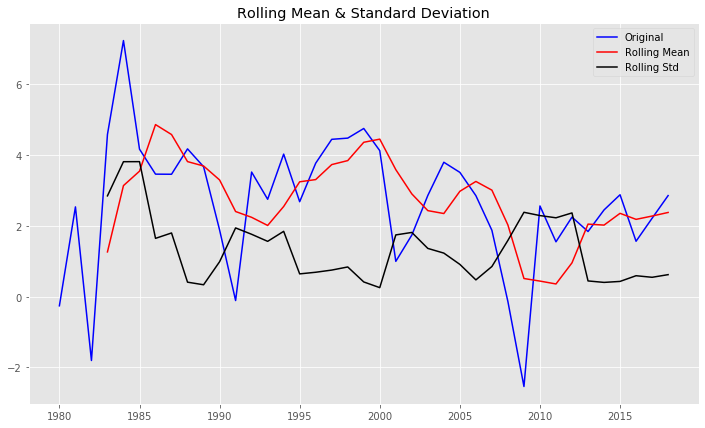

In [300]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(us_growth_train, color='blue',label='Original')
mean = plt.plot(ROL_M_US_GROWTH, color='red', label='Rolling Mean')
std = plt.plot(ROL_STD_US_GROWTH, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [25]:
# USA GROWTH ROLLING STATS
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x= us_growth_train.index,
               y= us_growth_train,
               name="USA GROWTH"), secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= ROL_M_US_GROWTH.index,
               y= ROL_M_US_GROWTH,
               name="Rolling MEAN USA GROWTH"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( x= ROL_STD_US_GROWTH.index,
               y= ROL_STD_US_GROWTH,
               name="Rolling STD USA GROWTH"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rolling STATS for USA GROWTH"
) # xaxis_rangeslider_visible=True

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="growth, %", secondary_y=False)
fig.update_yaxes(title_text="%", secondary_y=True)
fig.write_image('images/fig6.png')

fig.show()

You can use the Dicky-Fuller test to check the stationarity of the time series data.

The null hypothesis  Ho  assumes that the time series is dependent on time (that it is non-stationary). Since the Test Statistic is larger than the Critical Values, we cannot reject the null hypothesis and understand that the series is non-stationary

In [41]:
#create a function that will help us to quickly 
def test_stationarity(timeseries, window, name, n):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

#     #Plot rolling statistics:
#     fig = plt.figure(figsize=(12, 8))
#     orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show()
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(x= timeseries.index,
               y= timeseries,
               name= 'original'), secondary_y=False)

    fig.add_trace(go.Scatter(x= rolmean.index,
               y= rolmean,
               name="Rolling MEAN"), secondary_y=False)

    fig.add_trace(go.Scatter( x= rolstd.index, y= rolstd,
               name='Rolling STD'), secondary_y=True)

    # Add figure title
    fig.update_layout(title_text="Rolling STATS for {}".format(name)) # xaxis_rangeslider_visible=True

    fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=5)

    # Set x-axis title
    fig.update_xaxes(title_text="year")

    # Set y-axes titles
    fig.update_yaxes(title_text="measures", secondary_y=False)
    fig.update_yaxes(title_text="measures", secondary_y=True)
    fig.write_image('images/fig{}.png'.format(n))

    fig.show()
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [40]:
test_stationarity(us_gdp_train, 4, 'USA GDP', 7)

Results of Dickey-Fuller Test:
Test Statistic                  2.544136
p-value                         0.999063
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [42]:
test_stationarity(world_gdp_train, 4, 'WORLD GDP', 8)

Results of Dickey-Fuller Test:
Test Statistic                  1.357629
p-value                         0.996913
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [43]:
test_stationarity(us_growth_train, 4, 'USA GROWTH', 9)

Results of Dickey-Fuller Test:
Test Statistic                 -4.434479
p-value                         0.000258
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [44]:
test_stationarity(world_growth_train, 4, 'WORLD GROWTH', 10)

Results of Dickey-Fuller Test:
Test Statistic                 -4.584593
p-value                         0.000138
#Lags Used                      1.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


***
***
# PART_3
***
***

In [307]:
# log_transformation
# subtract rolling mean
# differecing
# pandas diff(periods= 1)
# decomposition
# decompostion= seasonal_decompose()
# trend= decomposition.trend
# seasonal= decomposition.seasonal
# residual= decomposition.resid

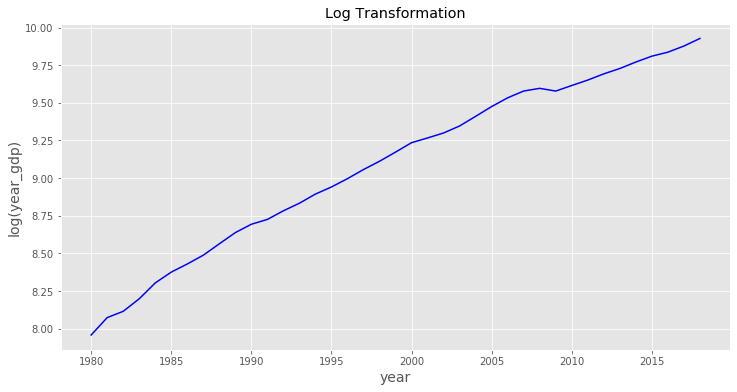

In [308]:
log_us_gdp = pd.Series(np.log(us_gdp_train))
fig = plt.figure(figsize=(12,6))
plt.plot(log_us_gdp, color="blue")
plt.xlabel("year", fontsize=14)
plt.ylabel("log(year_gdp)", fontsize=14)
plt.title('Log Transformation')
plt.show()

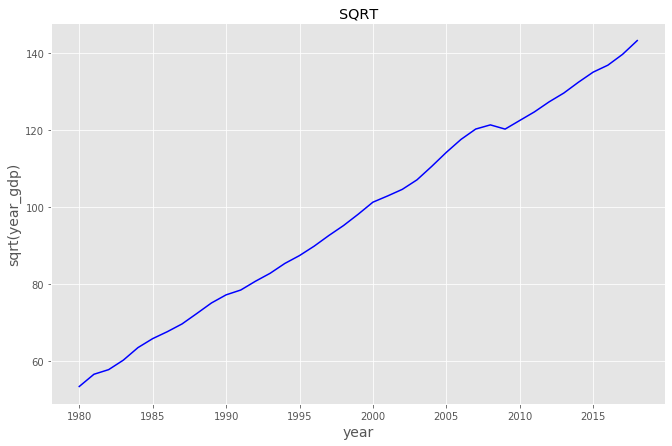

In [309]:
sqrt_us_gdp = pd.Series(np.sqrt(us_gdp_train))
fig = plt.figure(figsize=(11,7))
plt.plot(sqrt_us_gdp, color="blue")
plt.xlabel("year", fontsize=14)
plt.ylabel("sqrt(year_gdp)", fontsize=14)
plt.title('SQRT')
plt.show()

Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of an observation at a particular time instant with that at the previous instant (i.e. a co-called 1-period "lag"). 


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



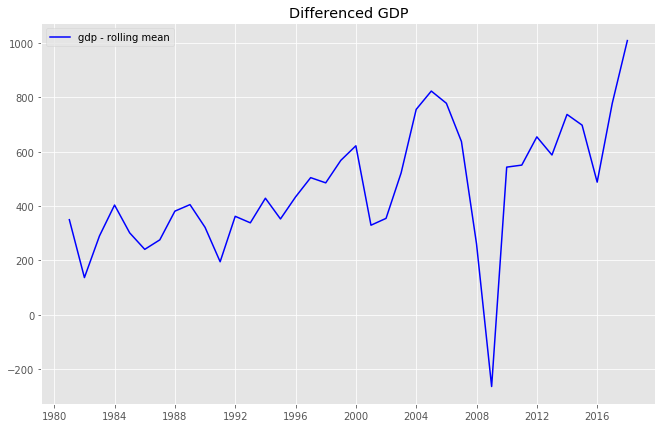

In [45]:
us_gdp_diff = us_gdp_train.diff(periods=1)
us_gdp_diff.head(10)

fig = plt.figure(figsize=(11,7))
plt.plot(us_gdp_diff, color='blue',label='gdp - rolling mean')
plt.legend(loc='best')
plt.title('Differenced GDP')
plt.show(block=False)

In [46]:
us_gdp_diff= us_gdp_diff.dropna()

In [53]:
test_stationarity(us_gdp_train.diff(periods=3).dropna(), 4, 'USA GDP DIFF', 11)

Results of Dickey-Fuller Test:
Test Statistic                 -2.968639
p-value                         0.037929
#Lags Used                      1.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [54]:
# decomposition = seasonal_decompose(us_gdp_train, model= 'multiplicative', freq= 1)

# # Gather the trend, seasonality and noise of decomposed object
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# # Plot gathered statistics
# plt.figure(figsize=(12,8))
# plt.subplot(411)
# plt.plot(us_gdp_train, label='Original', color="blue")
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend, label='Trend', color="blue")
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(seasonal,label='Seasonality', color="blue")
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual, label='Residuals', color="blue")
# plt.legend(loc='best')
# plt.tight_layout()

***
***
# PART_4
***
***

In [314]:
us_gdp= us_gdp_train.shift(periods= 1)
lag1= pd.concat([us_gdp, us_gdp_train], axis= 1)
lag1.corr()

US_GDP   US_GDP
US_GDP  1.00000  0.99931
US_GDP  0.99931  1.00000

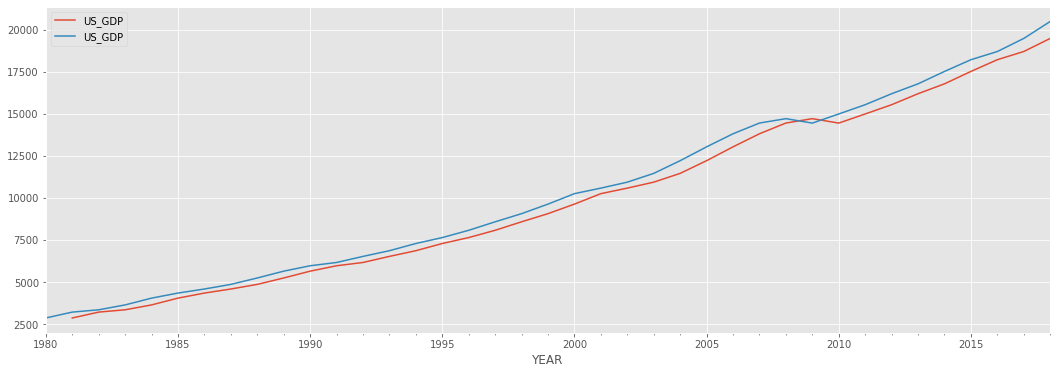

In [315]:
lag1.plot(figsize=(18,6))

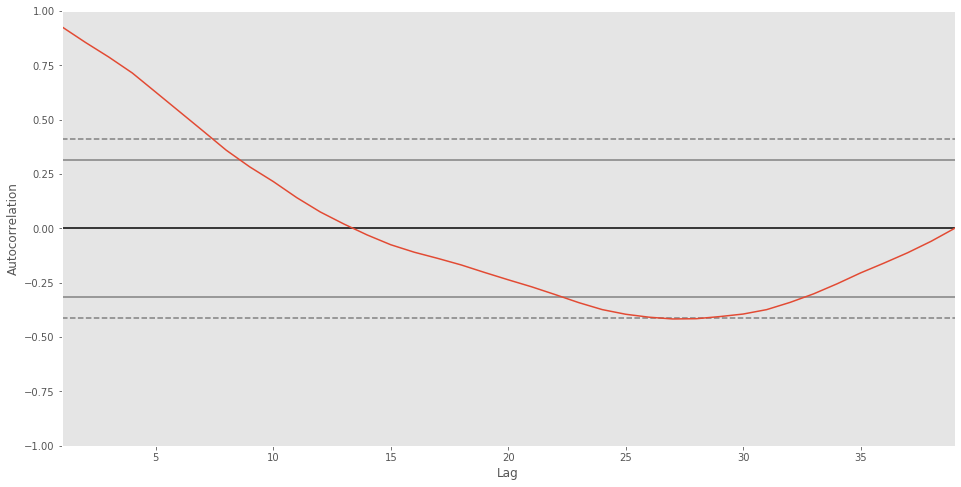

In [316]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(world_gdp_train);

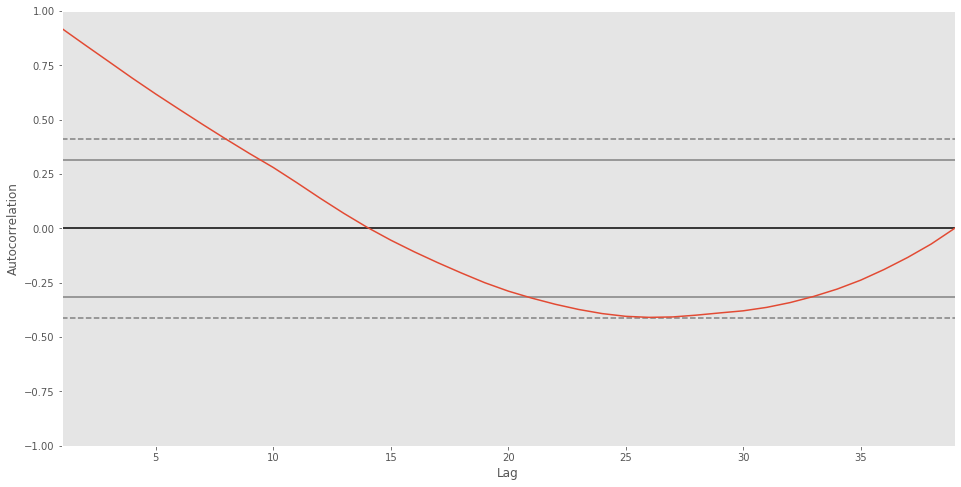

In [317]:
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(us_gdp_train);

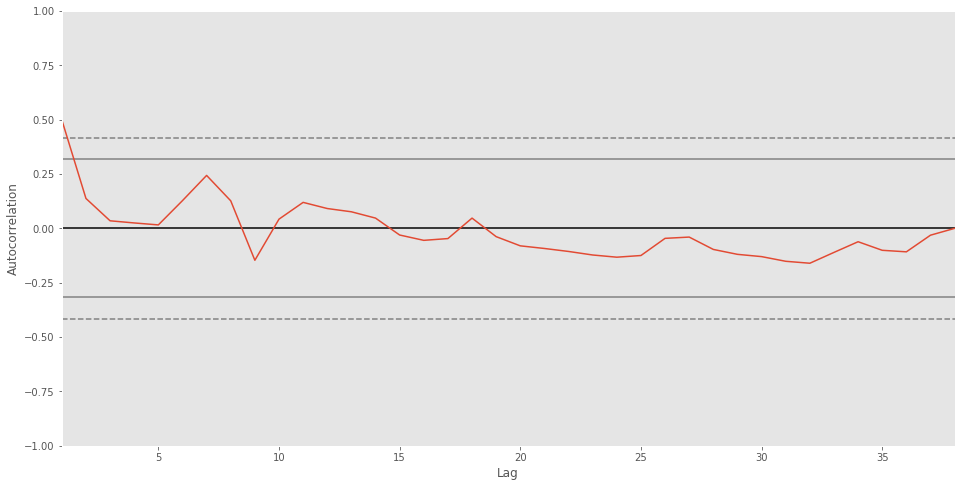

In [318]:
us_gdp_diff= us_gdp_train.diff(periods= 1)
us_gdp_diff.dropna(inplace= True)
plt.figure(figsize=(16,8))
pd.plotting.autocorrelation_plot(us_gdp_diff);

### PART_4.1 SAMPLE AUTOCORRELATION FUNCTION (ACF)

A sample autocorrelation function (ACF)for a series gives correlations between the series $x_t$ and lagged values of the series for lags 1, 2, 3, and so on. The lagged values can be written as $x_{t-1}, x_{t-2}, x_{t-3}$, and so on. The ACF gives correlations between $x_t$ and $x_{t-1}$, $x_t$ and $x_{t-2}$, and so on.

The ACF can be used to identify possible structure of time series data.


### The Partial Autocorrelation Function

Similarly to the Autocorrelation Function, the **Partial Autocorrelation Function** (or PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags. PACF can be thought of as a summary of the relationship between a time series element with observations at a lag, *with the relationships of intervening observations removed*.

The partial autocorrelation function can be interpreted as a regression of the series against its past lags. It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. The use of PACF will become more clear when we will be looking at some more "advanced" time series next!

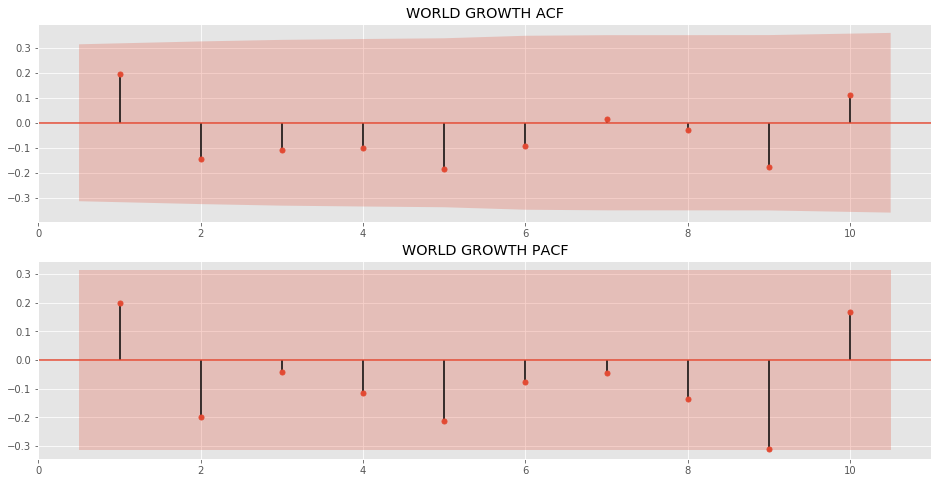

In [60]:
# WORLD_GROWTH_ACF AND PACF

fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_growth_train, lags=10, title= 'WORLD GROWTH ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_growth_train, lags=10, title= 'WORLD GROWTH PACF', zero= False, ax=ax2)

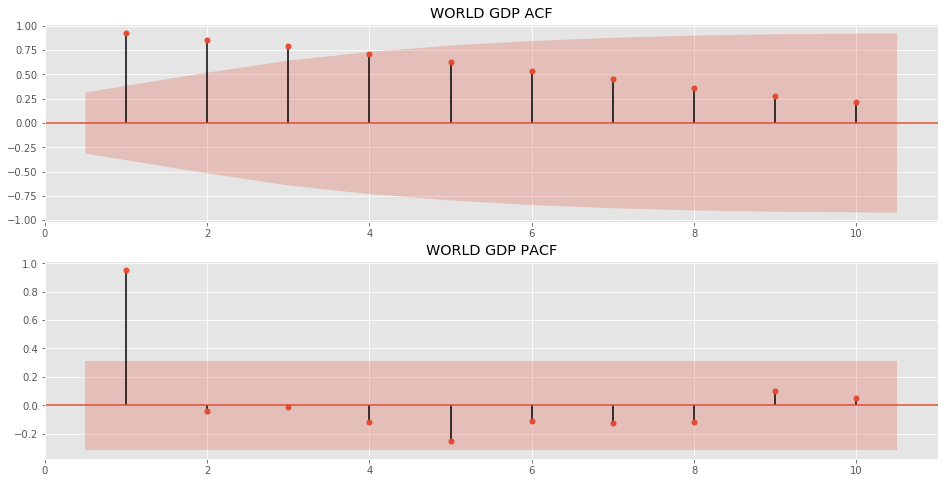

In [61]:
# WORLD GDP ACF AND PACF
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(world_gdp_train, lags=10, title='WORLD GDP ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(world_gdp_train, lags=10, title= 'WORLD GDP PACF', zero= False, ax=ax2)

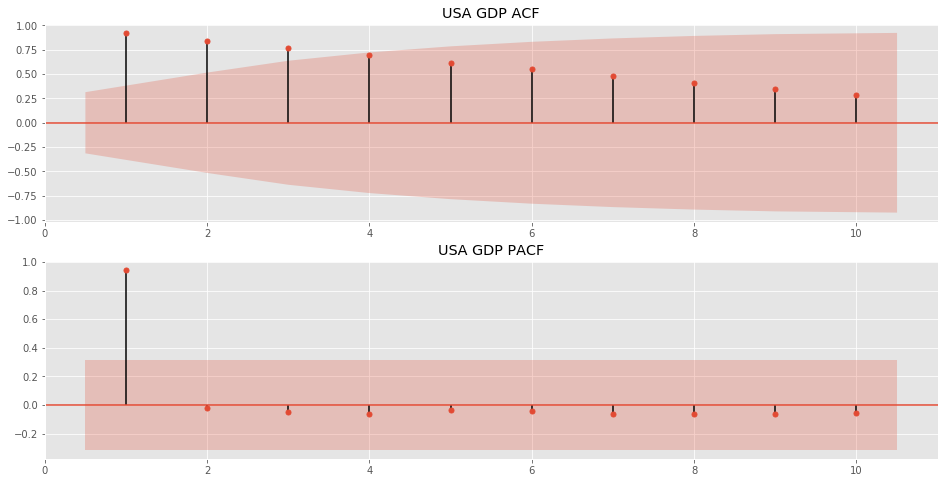

In [58]:
# US GDP ACF AND PACF
fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(us_gdp_train, lags=10, title='USA GDP ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(us_gdp_train, lags=10, title= 'USA GDP PACF', zero= False, ax=ax2)

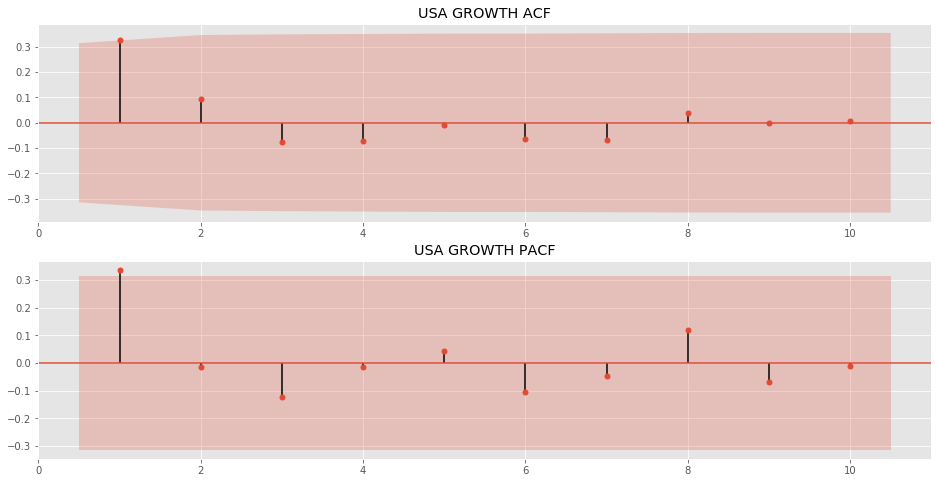

In [57]:
#USA GROWTH ACF PACF

fig = plt.figure(figsize=(16,8))

#plot the ACF

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(us_growth_train, lags=10, title='USA GROWTH ACF', zero= False, ax=ax1)

#plot the PACF

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(us_growth_train, lags=10, title= 'USA GROWTH PACF', zero= False, ax=ax2)

In [323]:
# def explore_first_difference(Series, n):
#     '''
#     Input: pandas.Series, number of differnces
#     Output: 
#     '''
#     diff= Series.diff(n)
    
#     fig = plt.figure(figsize=(16,8))
    
#     # plot difference
#     ax1= fig.add_subplot(211)
#     plt.plot(diff, ax= ax1)
    
#     #plot the ACF
#     ax2 = fig.add_subplot(212)
#     fig = sm.graphics.tsa.plot_acf(diff, lags=18, ax=ax2)
    
#     #plot the PACF
#     ax3 = fig.add_subplot(213)
#     fig = sm.graphics.tsa.plot_pacf(diff, lags=18, ax=ax3)

In [324]:
# first_diff= world_growth_train.diff(1)
# plt.plot(first_diff)

In [325]:
#sm.graphics.tsa.plot_acf(first_diff, title='none')

In [326]:
#explore_first_difference(world_gdp_train, 1)

One of the simplest ARIMA type models is a model in which we use a linear model to predict the value at the present time using the value at the previous time. This is called __an AR(1) model__, standing for autoregressive model of order 1. The order of the model indicates how many previous times we use to predict the present time.

In [327]:
# create a function which outputs a dataframe with lags
def shift_n (Series, n):
    '''
    Input: pandas.Series, number of lags
    Ouput: dataFrame
    '''
    data= pd.DataFrame(Series)
    data['lag']= data.shift(n)
    return data

In [328]:
data= shift_n(world_gdp_train, 1)

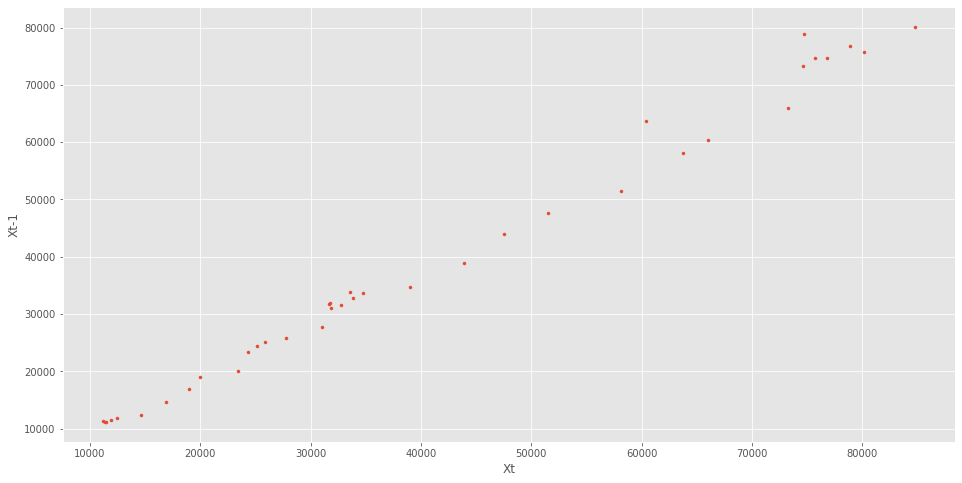

In [329]:
plt.figure(figsize= (16, 8))
plt.scatter(data.WORLD_GDP, data.lag, marker= '.')
plt.xlabel('Xt')
plt.ylabel('Xt-1')
plt.show()

the same with plotly

In [330]:
dat= go.Scatter(x= data.WORLD_GDP, y= data.lag,
                 mode= 'markers', marker=dict(size=list(range(10, 100, 10))*1000, color=[0, 1, 2, 3])
                 )

fig= go.Figure(data= dat)

fig.show()

the AR(1) model is written:
$x_t = \delta + \phi_1x_t-1 + \epsilon_t$

Assumptions:
- $\epsilon_t \stackrel{\text{iid}}{\sim} N(0, \sigma^2_t)$, meaning that the errors are independently distributed with a normal distribution that has mean 0 and constant variance;
- Properties of the errors $\epsilon_t$ are independent of $x$.

## PART_4.2 MODELING

In [331]:
# create train/test split
train= data_train.WORLD_GDP.iloc[: ceil(.8*len(data))]
test= data_train.WORLD_GDP.iloc[len(train) : ]

In [332]:
# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

a lag value chose is 9
the coefs are:
 const          -198.082576
L1.WORLD_GDP      1.004984
L2.WORLD_GDP     -0.234515
L3.WORLD_GDP      0.554258
L4.WORLD_GDP      0.117126
L5.WORLD_GDP     -0.628361
L6.WORLD_GDP     -0.482215
L7.WORLD_GDP      0.783994
L8.WORLD_GDP     -0.106731
L9.WORLD_GDP      0.104666
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

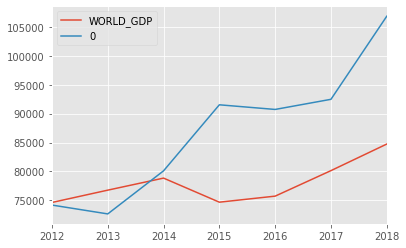

In [333]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

In [334]:
print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

r2 score: -13.661876624197705
RMSE: 12914.779663027884


GROWTH

a lag value chose is 9
the coefs are:
 const              9.610817
L1.WORLD_GROWTH   -0.042274
L2.WORLD_GROWTH   -0.245613
L3.WORLD_GROWTH   -0.361858
L4.WORLD_GROWTH   -0.463648
L5.WORLD_GROWTH   -0.495068
L6.WORLD_GROWTH    0.131543
L7.WORLD_GROWTH   -0.278283
L8.WORLD_GROWTH    0.159511
L9.WORLD_GROWTH   -0.646063
dtype: float64


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



<Figure size 1152x576 with 0 Axes>

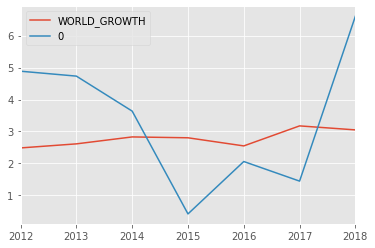

r2 score: -80.13538470438732
RMSE: 2.151425410397956


In [335]:
# create train/test split
number= len(world_growth_train)
train= world_growth_train.iloc[: ceil(.8*number)]
test= world_growth_train.iloc[len(train):]

# train a model
model= AR(train)
model_fitted= model.fit()

print(f'a lag value chose is {model_fitted.k_ar}')
print(f'the coefs are:\n {model_fitted.params}' )

# make predictions 
predictions = model_fitted.predict(
    start=len(train), 
    end=len(train) + len(test)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [test,
    predictions], axis=1)

#plot the two values
plt.figure(figsize= (16, 8))
compare_df.plot()
plt.show()

print(f'r2 score: {r2_score(test, predictions)}')
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions))}')

# RESIDUAL ANALYSIS#

In [336]:
# mod= ARIMA(data_train.WORLD_GROWTH, (1, 1, 0))
# res= mod.fit()

In [337]:
# res.summary()

In [338]:
# data_train['predict'] = res.predict(start= 32, end= 39, dynamic= False)  
# data_train[['WORLD_GROWTH', 'predict']].plot(figsize=(16, 12)) 

In [339]:
#world_growth_train

***
# MODEL SELECTION
***
***

In [64]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

In [79]:
# Run a grid with pdq parameters calculated above and get the best AIC value

def best_param(Series):
    aic= []
    bic= []
    for comb in pdq:
        try:
            model= sm.tsa.statespace.SARIMAX(Series,
                                order= comb,
                                enforce_stationarity= False, enforce_invertibility= False
                                 )

            output= model.fit()
            aic.append([comb, output.aic])
            bic.append([comb, output.bic])
            print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
            print('ARIMA {} : BIC Calculated ={}'.format(comb, output.bic))
        except:
            continue
   
    # Find the parameters with minimal AIC value.

    aicFrame = pd.DataFrame(aic, columns=['COMBINATION', 'AIC'])
    bicFrame = pd.DataFrame(bic, columns=['COMBINATION', 'BIC'])
    AIC= aicFrame.loc[aicFrame['AIC'].idxmin()]
    BIC= bicFrame.loc[bicFrame['BIC'].idxmin()]
    return print(AIC, '\n', BIC)

In [80]:
best_param(us_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249
ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 0) : BIC Calculated =521.9969012720277
ARIMA (1, 0, 1) : AIC Calculated =497.2968052520717
ARIMA (1, 0, 1) : BIC Calculated =502.12955899000434
ARIMA (1, 0, 2) : AIC Calculated =485.6867789737026
ARIMA (1, 0, 2) : BIC Calculated =492.020854727527
ARIMA (1, 1, 0) : AIC Calculated =505.3900634769632
ARIMA (1, 1, 0) : BIC Calculated =508.61189930225163
ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093
ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905
ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1,

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307
ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617
ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116
ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412
ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335
COMBINATION    (0, 2, 2)
AIC              462.141
Name: 8, dtype: object 
 COMBINATION    (0, 2, 2)
BIC               466.72
Name: 8, dtype: object


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



# GRID SEARCH ???

In [69]:
# # Perform grid search for the ARIMA model.
# stepwise_model = auto_arima(us_gdp_train, start_p=0, start_q=0, start_d= 0, max_p=5, max_q=5, seasonal=False, D=0, 
#                             trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
# print(stepwise_model.aic())

In [70]:
# # plug the optimal parameter values into a new SARIMAX model.
# ARIMA_MODEL = sm.tsa.ARIMA(us_gdp_train,
#                                 order=(0, 2, 2),
#                                )

# # Fit the model and print results

# output = ARIMA_MODEL.fit()

# print(output.summary())


In [71]:
# fig, ax = plt.subplots()
# ax = us_gdp_train.loc['1980':].plot(ax=ax)
# fig = output.plot_predict('2014', '2018', dynamic=True, ax=ax, plot_insample=False, alpha= .05)
# plt.show()

In [72]:
# # plug the optimal parameter values into a new SARIMAX model.
# SARIMAX_MODEL = sm.tsa.statespace.SARIMAX(us_gdp_train,
#                                 order=(0, 2, 2), enforce_stationarity= False, enforce_invertibility= False
#                                )

# # Fit the model and print results

# output = SARIMAX_MODEL.fit()

# print(output.summary())

In [73]:
# # Use plot_diagnostics with results calculated above.
# output.plot_diagnostics(figsize=(15, 18))
# plt.show()

In [348]:
# Get predictions starting from 01-01-2011 and calculate confidence intervals.

pred = output.get_prediction(start='2011-01-01', dynamic=False)
pred_conf = pred.conf_int()

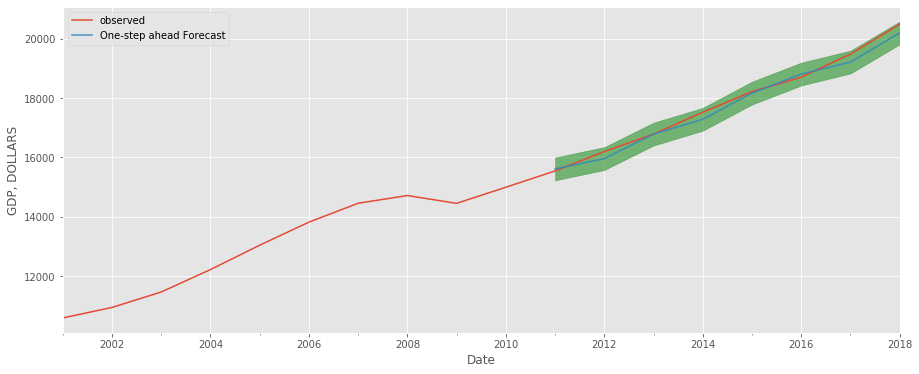

In [349]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = us_gdp_train['2001':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range bfor confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')
plt.legend()

plt.show()

In [350]:
# Get the Real and predicted values
GDP_forecasted = pred.predicted_mean
GDP_truth= us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36153.88


# DYNAMIC

In [351]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

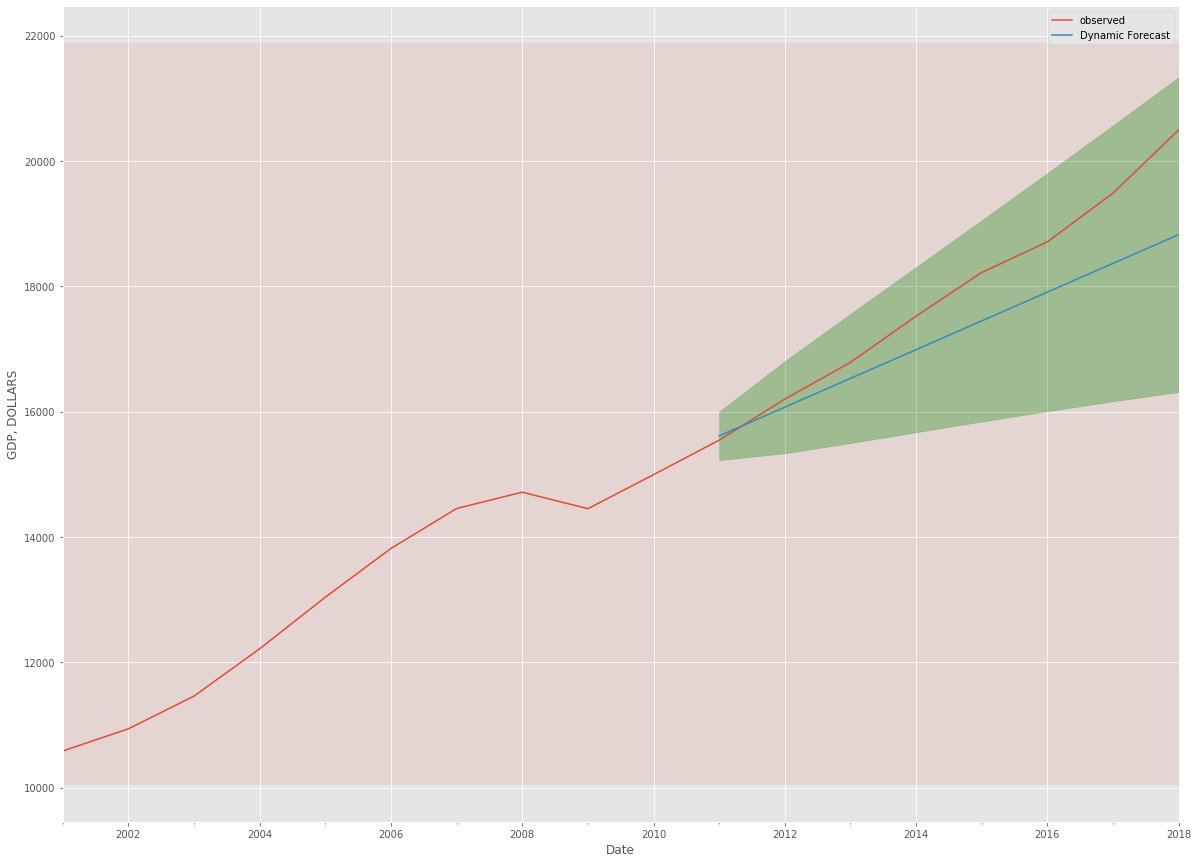

In [352]:
# Plot the dynamic forecast with confidence intervals.

ax = us_gdp_train['2001':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2001-01-01'), GDP_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

In [353]:
# Extract the predicted and true values of our time series
GDP_forecasted = pred_dynamic.predicted_mean
GDP_truth = us_gdp_train['2011-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 707785.04


In [354]:
# Get forecast 10 steps ahead in future
prediction = output.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

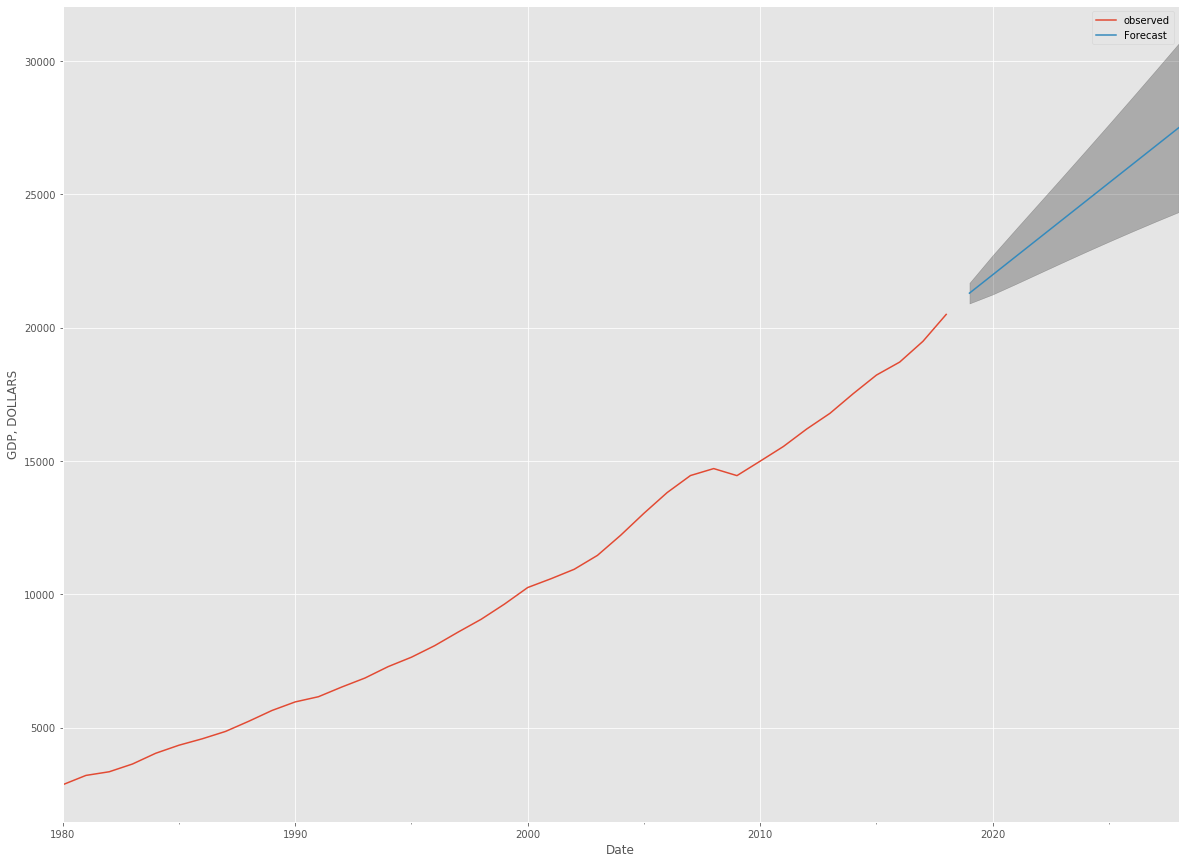

In [355]:
# Plot future predictions with confidence intervals

ax = us_gdp_train.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GDP, DOLLARS')

plt.legend()
plt.show()

# PREDICTIONS

In [77]:
def analyse_series (Series, Series2, p, d, q, year):
    '''
    Input: Time Series, parametrs, starting year
    Output:
    '''
    # plug the optimal parameter values into a new SARIMAX model.
    model= sm.tsa.statespace.SARIMAX(Series,
                                order=(p, d, q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    # fit the model and print results

    output = model.fit()

    print(output.summary())
    
    # Use plot_diagnostics with results calculated above.
    output.plot_diagnostics(figsize=(18, 18))
    plt.show()
    
    # Get predictions starting from 01-01-year and calculate confidence intervals.

    prediction = output.get_prediction(start='{}-01-01'.format(year), dynamic=False)
    int_ = prediction.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 16, 8

    #Plot observed values
    ax = Series[f'{year-10}':].plot(label='observed')

    #Plot predicted values
    prediction.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.5)

    #Plot the range for confidence intervals
    ax.fill_between(int_.index,
                int_.iloc[:, 0],
                int_.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
    ax.set_xlabel('date')
    ax.set_ylabel('prediction')
    plt.legend()

    plt.show()
    
    # Extract the predicted and true values of our time series
    forecast= prediction.predicted_mean
    true= Series['{}-01-01'.format(year):]

    # Compute the mean squared error and root mean squared error
    mse = ((forecast - true) ** 2).mean()
    print('The Mean Squared Error is: {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error is: {}'.format(round(np.sqrt(mse), 2)))
    
    to_2024= output.get_prediction('2019', '2024', dynamic= False)
    to_2024= to_2024.predicted_mean
    comp= pd.concat([to_2024, Series2], axis= 1)
    comp.plot();
    mse_forecast= mean_squared_error(to_2024, Series2)
    print('The Root Mean Squared Error of Forecast is: {}'.format(round(np.sqrt(mse_forecast), 2)))

# PREDICT US_GDP

In [81]:
best_param(us_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =821.5562544881302
ARIMA (0, 0, 0) : BIC Calculated =823.1938406478566
ARIMA (0, 0, 1) : AIC Calculated =875.8357170376365
ARIMA (0, 0, 1) : BIC Calculated =879.0575528629249
ARIMA (0, 0, 2) : AIC Calculated =842.7313573621585
ARIMA (0, 0, 2) : BIC Calculated =847.4819141775268
ARIMA (0, 1, 0) : AIC Calculated =569.9437258822463
ARIMA (0, 1, 0) : BIC Calculated =571.5546437948906
ARIMA (0, 1, 1) : AIC Calculated =528.4209300773188
ARIMA (0, 1, 1) : BIC Calculated =531.587967954231
ARIMA (0, 1, 2) : AIC Calculated =498.2782134760084
ARIMA (0, 1, 2) : BIC Calculated =502.94425766047664
ARIMA (0, 2, 0) : AIC Calculated =490.2026473622819
ARIMA (0, 2, 0) : BIC Calculated =491.786166300738
ARIMA (0, 2, 1) : AIC Calculated =478.4746489450628
ARIMA (0, 2, 1) : BIC Calculated =481.58534506804165
ARIMA (0, 2, 2) : AIC Calculated =462.1405159534188
ARIMA (0, 2, 2) : BIC Calculated =466.7195975272673
ARIMA (1, 0, 0) : AIC Calculated =518.721728952575
ARIMA (1, 0, 

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (1, 1, 1) : AIC Calculated =490.089289342641
ARIMA (1, 1, 1) : BIC Calculated =494.8398461580093
ARIMA (1, 1, 2) : AIC Calculated =472.98212550557156
ARIMA (1, 1, 2) : BIC Calculated =479.2035177515292
ARIMA (1, 2, 0) : AIC Calculated =491.77746111634565
ARIMA (1, 2, 0) : BIC Calculated =494.94449899325787
ARIMA (1, 2, 1) : AIC Calculated =476.60817499532226
ARIMA (1, 2, 1) : BIC Calculated =481.2742191797905


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (1, 2, 2) : AIC Calculated =463.8532967525872
ARIMA (1, 2, 2) : BIC Calculated =469.95873885105186
ARIMA (2, 0, 0) : AIC Calculated =497.429455616674
ARIMA (2, 0, 0) : BIC Calculated =502.2622093546066
ARIMA (2, 0, 1) : AIC Calculated =498.28527292835906
ARIMA (2, 0, 1) : BIC Calculated =504.72894457893597
ARIMA (2, 0, 2) : AIC Calculated =487.6740495031502
ARIMA (2, 0, 2) : BIC Calculated =495.5916441954307


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 1, 0) : AIC Calculated =493.66691836582925
ARIMA (2, 1, 0) : BIC Calculated =498.4174751811976
ARIMA (2, 1, 1) : AIC Calculated =489.33611738065537
ARIMA (2, 1, 1) : BIC Calculated =495.6701931344798
ARIMA (2, 1, 2) : AIC Calculated =474.8621095531699
ARIMA (2, 1, 2) : BIC Calculated =482.638849860617
ARIMA (2, 2, 0) : AIC Calculated =478.8987734627529
ARIMA (2, 2, 0) : BIC Calculated =483.56481764722116
ARIMA (2, 2, 1) : AIC Calculated =475.67521637698354
ARIMA (2, 2, 1) : BIC Calculated =481.8966086229412


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 2) : AIC Calculated =465.2008156689025
ARIMA (2, 2, 2) : BIC Calculated =472.83261829198335
COMBINATION    (0, 2, 2)
AIC              462.141
Name: 8, dtype: object 
 COMBINATION    (0, 2, 2)
BIC               466.72
Name: 8, dtype: object


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:                 US_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -228.070
Date:                Wed, 31 Jul 2019   AIC                            462.141
Time:                        15:17:34   BIC                            466.720
Sample:                    01-01-1980   HQIC                           463.702
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3821      0.125     -3.048      0.002      -0.628      -0.136
ma.L2         -0.3664      0.197     -1.858      0.063      -0.753       0.020
sigma2      3.896e+04   9139.389      4.263      0.0

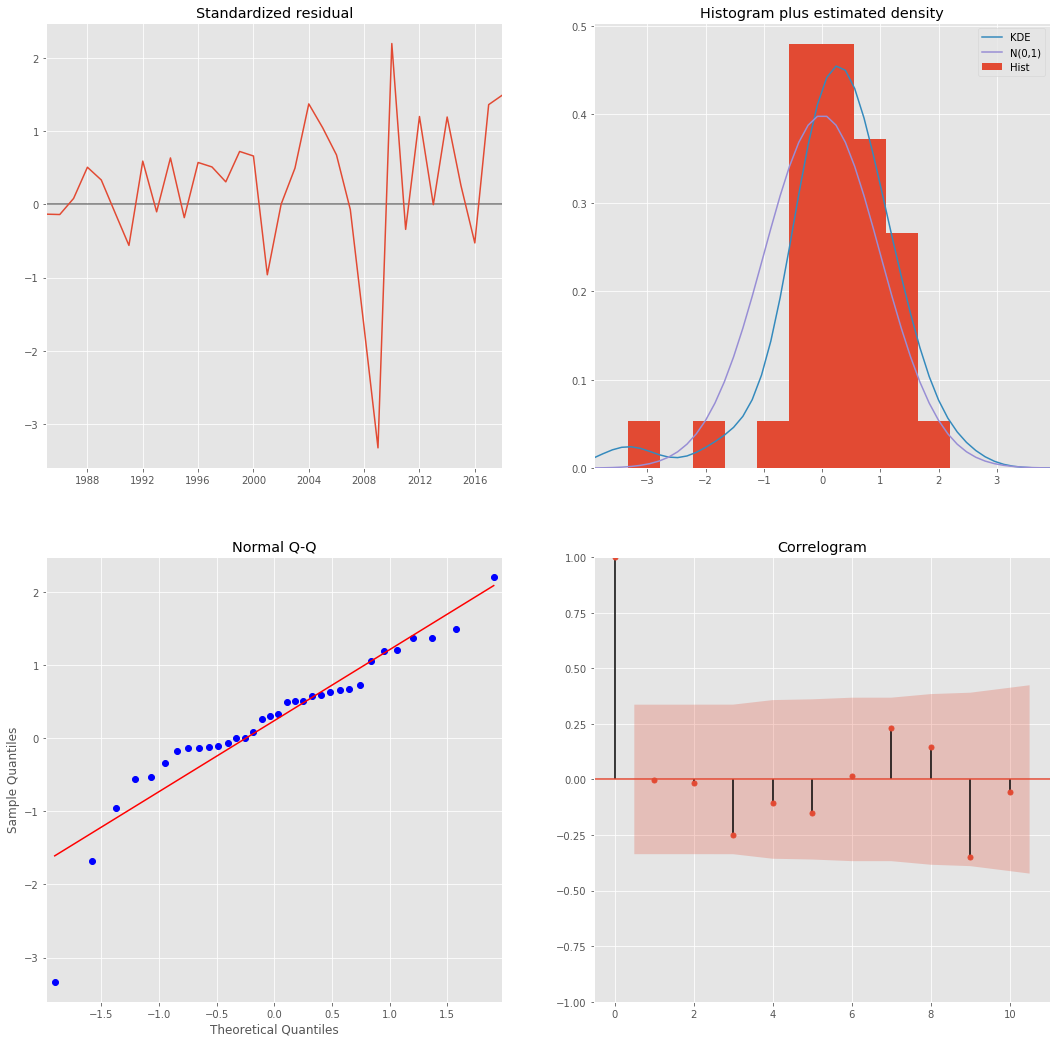

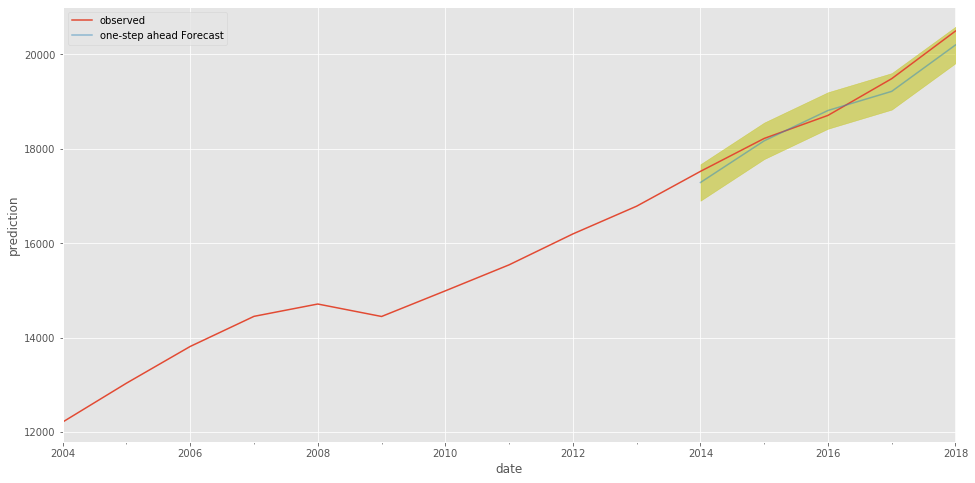

The Mean Squared Error is: 45689.42
The Root Mean Squared Error is: 213.75
The Root Mean Squared Error of Forecast is: 590.06


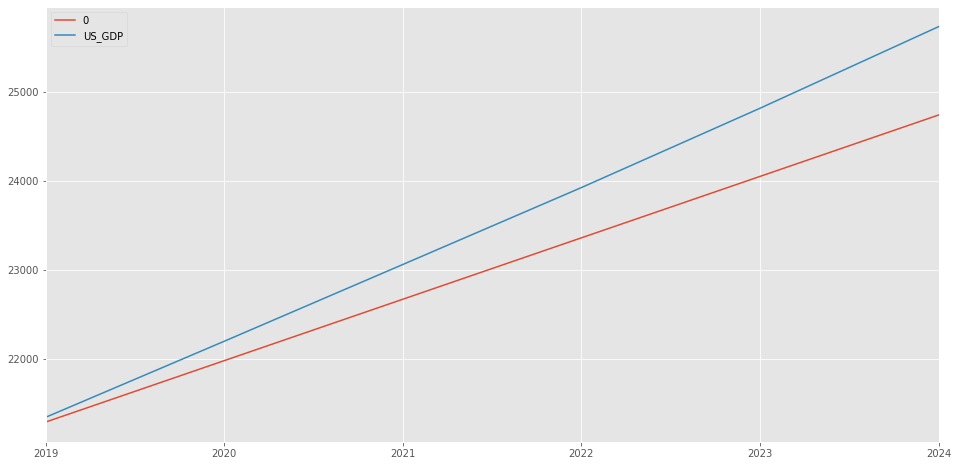

In [82]:
analyse_series(us_gdp_train, us_gdp_forecast, 0, 2, 2, 2014)

The purpose here to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model. 

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces has no correlations and provides a satisfactory fit to help forecast future values.

# PREDICT US_GROWTH

In [83]:
best_param(us_growth_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =199.32914397970922
ARIMA (0, 0, 0) : BIC Calculated =200.9667301394356
ARIMA (0, 0, 1) : AIC Calculated =173.0606319848677
ARIMA (0, 0, 1) : BIC Calculated =176.28246781015616
ARIMA (0, 0, 2) : AIC Calculated =153.06568922089247
ARIMA (0, 0, 2) : BIC Calculated =157.8162460362608
ARIMA (0, 1, 0) : AIC Calculated =160.80315610332013
ARIMA (0, 1, 0) : BIC Calculated =162.41407401596436
ARIMA (0, 1, 1) : AIC Calculated =148.13086573068568
ARIMA (0, 1, 1) : BIC Calculated =151.2979036075979
ARIMA (0, 1, 2) : AIC Calculated =133.79954031869602
ARIMA (0, 1, 2) : BIC Calculated =138.46558450316425
ARIMA (0, 2, 0) : AIC Calculated =188.1415460902471
ARIMA (0, 2, 0) : BIC Calculated =189.7250650287032
ARIMA (0, 2, 1) : AIC Calculated =144.75443560953863
ARIMA (0, 2, 1) : BIC Calculated =147.86513173251745
ARIMA (0, 2, 2) : AIC Calculated =140.31048267453247
ARIMA (0, 2, 2) : BIC Calculated =144.88956424838096
ARIMA (1, 0, 0) : AIC Calculated =164.08320686692227

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 0, 1) : AIC Calculated =153.35259054062576
ARIMA (2, 0, 1) : BIC Calculated =159.79626219120266
ARIMA (2, 0, 2) : AIC Calculated =150.17200010031507
ARIMA (2, 0, 2) : BIC Calculated =158.08959479259562
ARIMA (2, 1, 0) : AIC Calculated =152.73031389386927
ARIMA (2, 1, 0) : BIC Calculated =157.4808707092376
ARIMA (2, 1, 1) : AIC Calculated =147.07659600816137
ARIMA (2, 1, 1) : BIC Calculated =153.4106717619858
ARIMA (2, 1, 2) : AIC Calculated =135.45591801625002
ARIMA (2, 1, 2) : BIC Calculated =143.23265832369708


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ARIMA (2, 2, 0) : AIC Calculated =158.2312267967205
ARIMA (2, 2, 0) : BIC Calculated =162.89727098118874
ARIMA (2, 2, 1) : AIC Calculated =155.02328918235793
ARIMA (2, 2, 1) : BIC Calculated =161.24468142831557
ARIMA (2, 2, 2) : AIC Calculated =150.14647589086465
ARIMA (2, 2, 2) : BIC Calculated =157.77827851394545
COMBINATION    (0, 1, 2)
AIC                133.8
Name: 5, dtype: object 
 COMBINATION    (0, 1, 2)
BIC              138.466
Name: 5, dtype: object


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              US_GROWTH   No. Observations:                   39
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -63.900
Date:                Wed, 31 Jul 2019   AIC                            133.800
Time:                        15:23:43   BIC                            138.466
Sample:                    01-01-1980   HQIC                           135.410
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4660      0.148     -3.159      0.002      -0.755      -0.177
ma.L2         -0.4213      0.139     -3.024      0.002      -0.694      -0.148
sigma2         2.1860      0.574      3.807      0.0

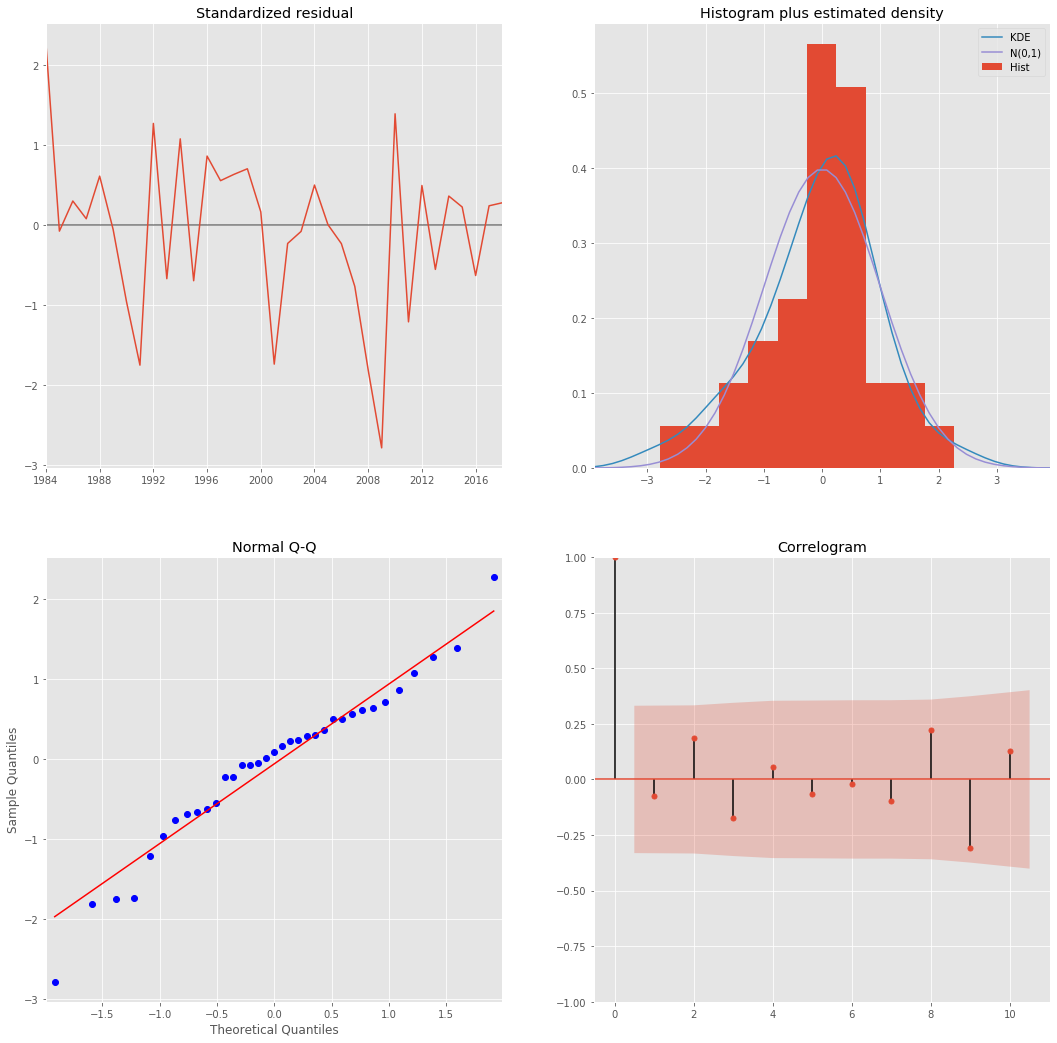

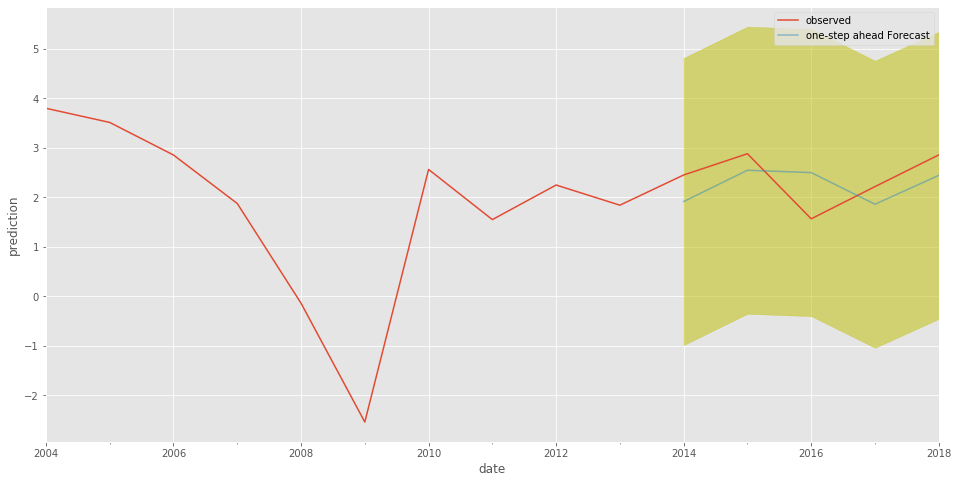

The Mean Squared Error is: 0.31
The Root Mean Squared Error is: 0.56
The Root Mean Squared Error of Forecast is: 0.61


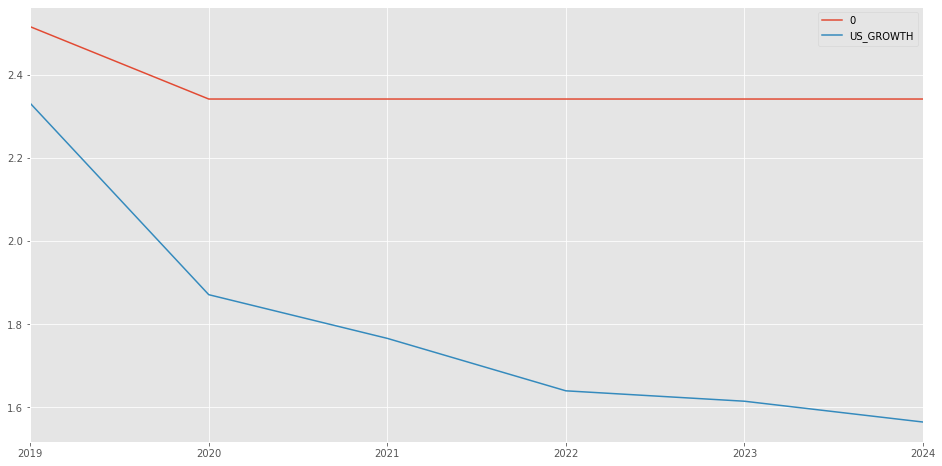

In [84]:
analyse_series(us_growth_train, us_growth_forecast, 0, 1, 2, 2014)

# PREDICT WORLD_GDP

In [85]:
best_param(world_gdp_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =928.1390318823977
ARIMA (0, 0, 0) : BIC Calculated =929.7766180421241
ARIMA (0, 0, 1) : AIC Calculated =880.9723305356902
ARIMA (0, 0, 1) : BIC Calculated =884.1941663609786
ARIMA (0, 0, 2) : AIC Calculated =857.2450239237735
ARIMA (0, 0, 2) : BIC Calculated =861.9955807391418
ARIMA (0, 1, 0) : AIC Calculated =702.3657451584414
ARIMA (0, 1, 0) : BIC Calculated =703.9766630710857
ARIMA (0, 1, 1) : AIC Calculated =675.183757534699
ARIMA (0, 1, 1) : BIC Calculated =678.3507954116112
ARIMA (0, 1, 2) : AIC Calculated =660.3986660819568
ARIMA (0, 1, 2) : BIC Calculated =665.064710266425
ARIMA (0, 2, 0) : AIC Calculated =681.0689408570591
ARIMA (0, 2, 0) : BIC Calculated =682.6524597955153
ARIMA (0, 2, 1) : AIC Calculated =653.981922924686
ARIMA (0, 2, 1) : BIC Calculated =657.0926190476649
ARIMA (0, 2, 2) : AIC Calculated =633.1387949164689
ARIMA (0, 2, 2) : BIC Calculated =637.7178764903174
ARIMA (1, 0, 0) : AIC Calculated =703.0694123656883
ARIMA (1, 0, 0)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 0, 0) : AIC Calculated =685.9802906534057
ARIMA (2, 0, 0) : BIC Calculated =690.8130443913384
ARIMA (2, 0, 1) : AIC Calculated =685.7668180905407
ARIMA (2, 0, 1) : BIC Calculated =692.2104897411176
ARIMA (2, 0, 2) : AIC Calculated =669.349789488216
ARIMA (2, 0, 2) : BIC Calculated =677.2673841804965
ARIMA (2, 1, 0) : AIC Calculated =676.3929340112732
ARIMA (2, 1, 0) : BIC Calculated =681.1434908266415
ARIMA (2, 1, 1) : AIC Calculated =673.2877144983848
ARIMA (2, 1, 1) : BIC Calculated =679.6217902522093


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so

ARIMA (2, 1, 2) : AIC Calculated =653.6937303720902
ARIMA (2, 1, 2) : BIC Calculated =661.4704706795372
ARIMA (2, 2, 0) : AIC Calculated =651.557338632103
ARIMA (2, 2, 0) : BIC Calculated =656.2233828165712
ARIMA (2, 2, 1) : AIC Calculated =653.2061985769099
ARIMA (2, 2, 1) : BIC Calculated =659.4275908228675
ARIMA (2, 2, 2) : AIC Calculated =635.5853697747737
ARIMA (2, 2, 2) : BIC Calculated =643.2171723978545
COMBINATION    (0, 2, 2)
AIC              633.139
Name: 8, dtype: object 
 COMBINATION    (0, 2, 2)
BIC              637.718
Name: 8, dtype: object


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:              WORLD_GDP   No. Observations:                   39
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -313.569
Date:                Wed, 31 Jul 2019   AIC                            633.139
Time:                        15:28:31   BIC                            637.718
Sample:                    01-01-1980   HQIC                           634.700
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5786      0.218     -2.653      0.008      -1.006      -0.151
ma.L2         -0.3711      0.135     -2.741      0.006      -0.636      -0.106
sigma2      5.516e+06   1.55e+06      3.561      0.0

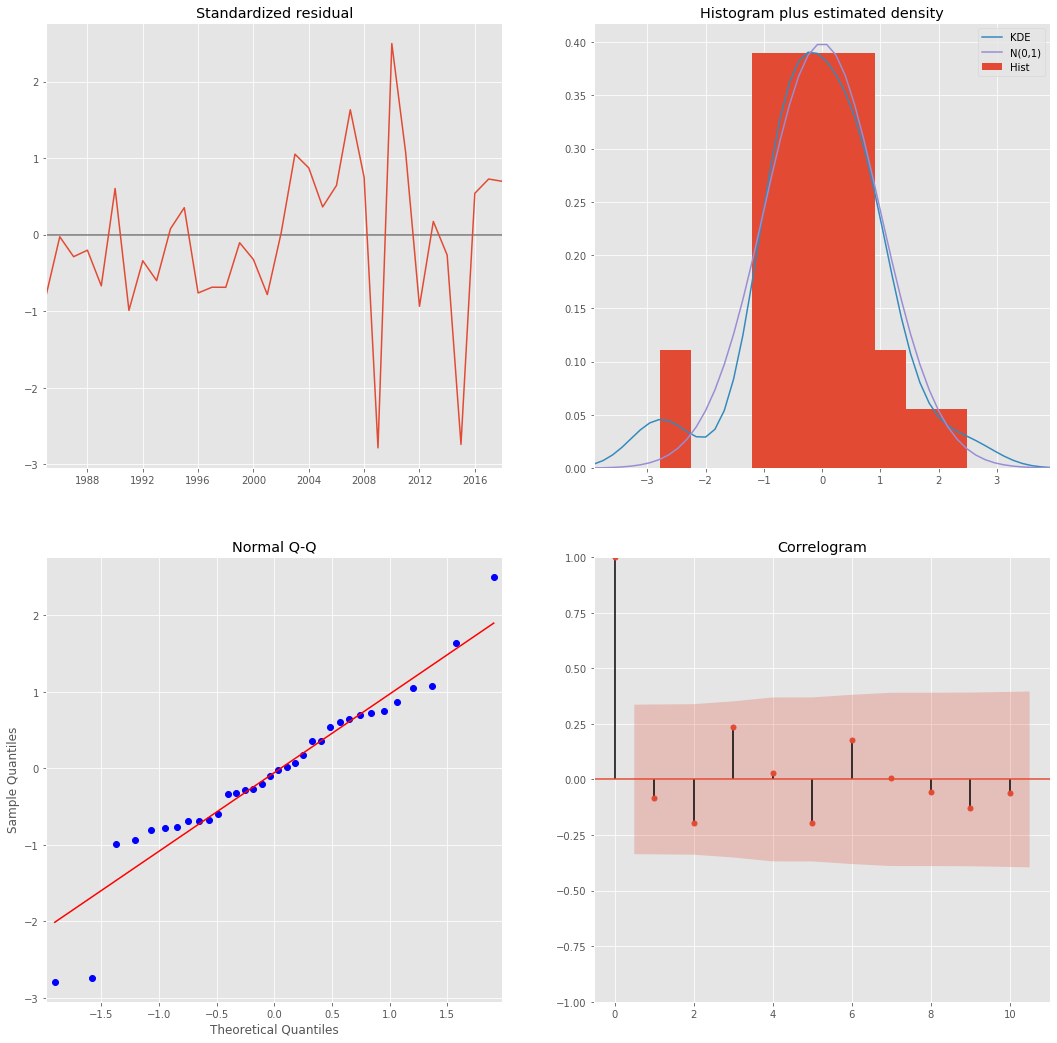

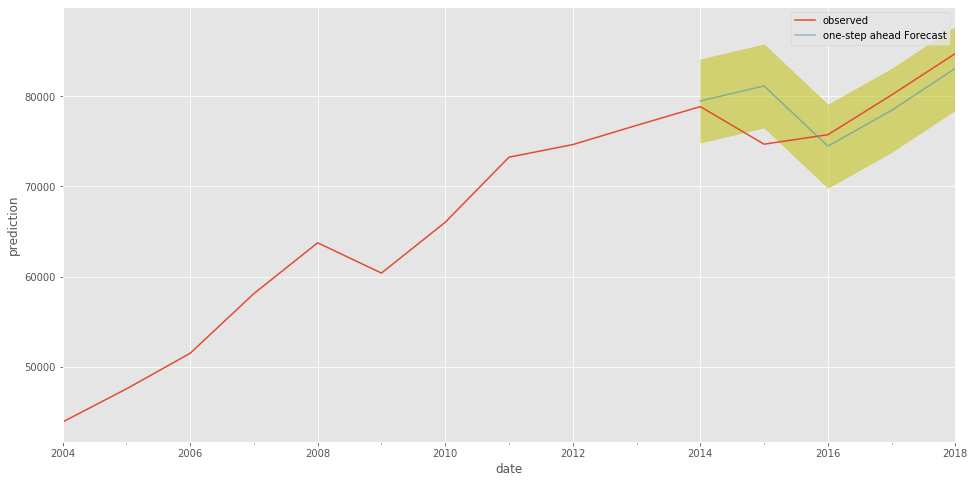

The Mean Squared Error is: 9860671.71
The Root Mean Squared Error is: 3140.17
The Root Mean Squared Error of Forecast is: 8462.64


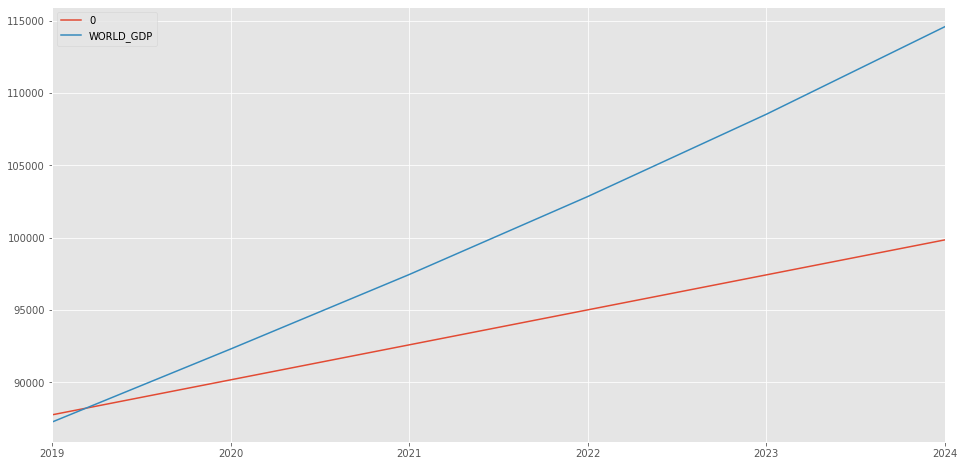

In [86]:
analyse_series(world_gdp_train, world_gdp_forecast, 0, 2, 2, 2014)

# PREDICT WORLD_GROWTH

In [87]:
best_param(world_growth_train)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (0, 0, 0) : AIC Calculated =196.27228945987454
ARIMA (0, 0, 0) : BIC Calculated =197.90987561960094
ARIMA (0, 0, 1) : AIC Calculated =167.7768945795683
ARIMA (0, 0, 1) : BIC Calculated =170.99873040485676
ARIMA (0, 0, 2) : AIC Calculated =155.70196866858103
ARIMA (0, 0, 2) : BIC Calculated =160.45252548394936
ARIMA (0, 1, 0) : AIC Calculated =140.42674545698554
ARIMA (0, 1, 0) : BIC Calculated =142.03766336962977
ARIMA (0, 1, 1) : AIC Calculated =124.25399713580633
ARIMA (0, 1, 1) : BIC Calculated =127.42103501271855
ARIMA (0, 1, 2) : AIC Calculated =120.0263536581579
ARIMA (0, 1, 2) : BIC Calculated =124.69239784262615
ARIMA (0, 2, 0) : AIC Calculated =171.30378677177234
ARIMA (0, 2, 0) : BIC Calculated =172.88730571022845
ARIMA (0, 2, 1) : AIC Calculated =136.1057788228356
ARIMA (0, 2, 1) : BIC Calculated =139.2164749458144
ARIMA (0, 2, 2) : AIC Calculated =125.3321553241814
ARIMA (0, 2, 2) : BIC Calculated =129.91123689802987
ARIMA (1, 0, 0) : AIC Calculated =143.0720028535017

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (1, 2, 2) : AIC Calculated =125.69600063807044
ARIMA (1, 2, 2) : BIC Calculated =131.80144273653508
ARIMA (2, 0, 0) : AIC Calculated =140.03182528577798
ARIMA (2, 0, 0) : BIC Calculated =144.86457902371066
ARIMA (2, 0, 1) : AIC Calculated =130.22251434759397
ARIMA (2, 0, 1) : BIC Calculated =136.66618599817087
ARIMA (2, 0, 2) : AIC Calculated =128.56939158821802
ARIMA (2, 0, 2) : BIC Calculated =136.4869862804986
ARIMA (2, 1, 0) : AIC Calculated =131.96362844745406
ARIMA (2, 1, 0) : BIC Calculated =136.71418526282238
ARIMA (2, 1, 1) : AIC Calculated =126.7197002158346
ARIMA (2, 1, 1) : BIC Calculated =133.05377596965906


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information wa

ARIMA (2, 1, 2) : AIC Calculated =121.47121131421777
ARIMA (2, 1, 2) : BIC Calculated =129.24795162166484
ARIMA (2, 2, 0) : AIC Calculated =148.2761427745972
ARIMA (2, 2, 0) : BIC Calculated =152.94218695906542
ARIMA (2, 2, 1) : AIC Calculated =134.86270636721622
ARIMA (2, 2, 1) : BIC Calculated =141.08409861317386
ARIMA (2, 2, 2) : AIC Calculated =129.3273253372381
ARIMA (2, 2, 2) : BIC Calculated =136.95912796031894
COMBINATION    (0, 1, 2)
AIC              120.026
Name: 5, dtype: object 
 COMBINATION    (0, 1, 2)
BIC              124.692
Name: 5, dtype: object


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                           Statespace Model Results                           
Dep. Variable:           WORLD_GROWTH   No. Observations:                   39
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -57.013
Date:                Wed, 31 Jul 2019   AIC                            120.026
Time:                        15:29:04   BIC                            124.692
Sample:                    01-01-1980   HQIC                           121.637
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7015   2841.100     -0.000      1.000   -5569.155    5567.752
ma.L2         -0.2985    847.917     -0.000      1.000   -1662.186    1661.589
sigma2         1.4075   3998.743      0.000      1.0

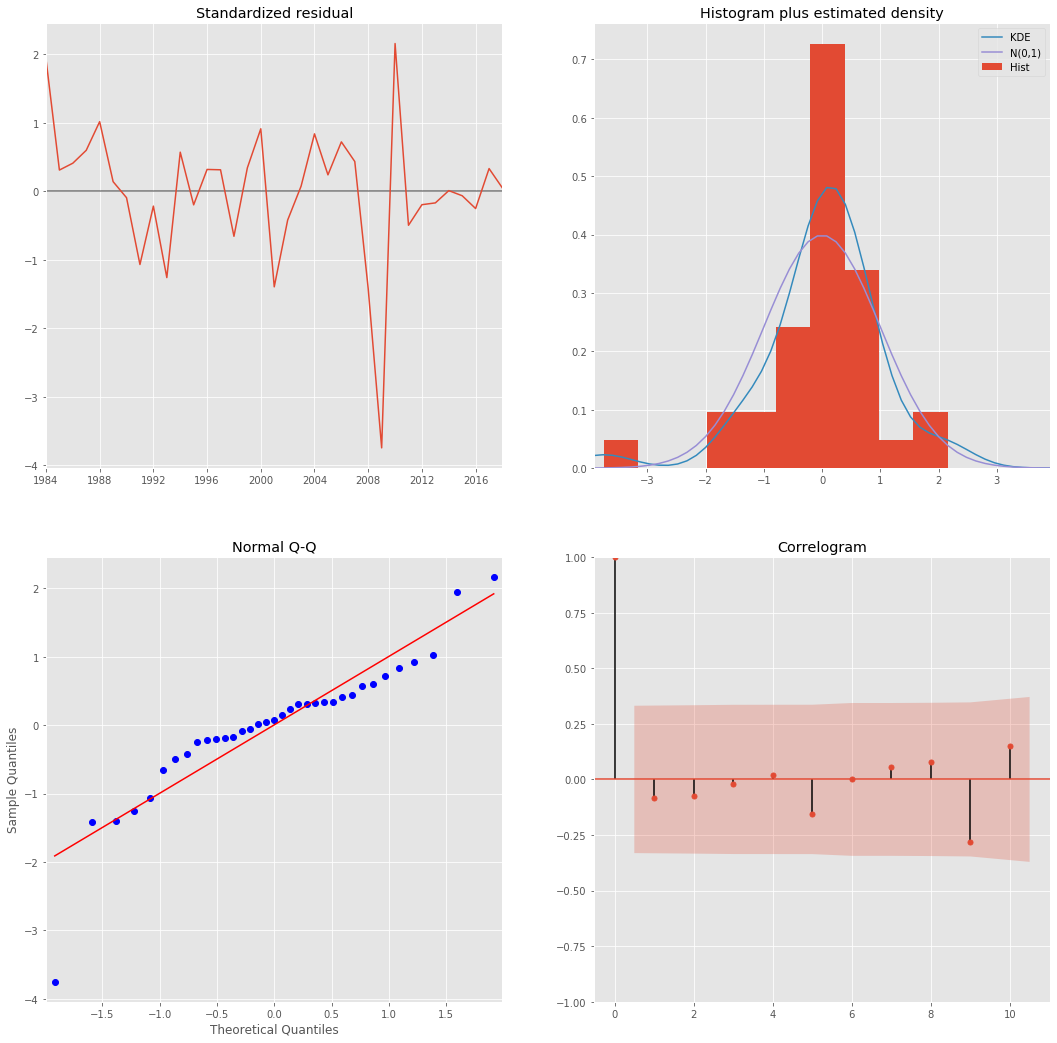

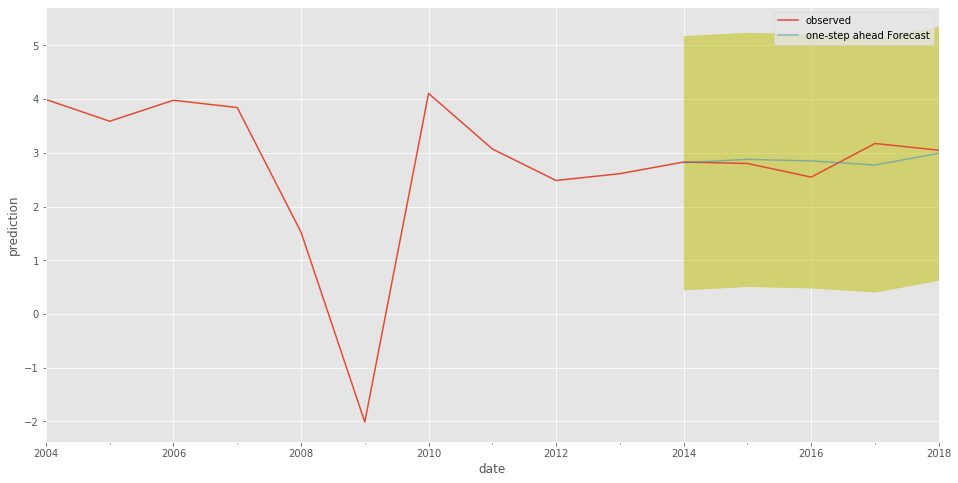

The Mean Squared Error is: 0.05
The Root Mean Squared Error is: 0.23
The Root Mean Squared Error of Forecast is: 0.07


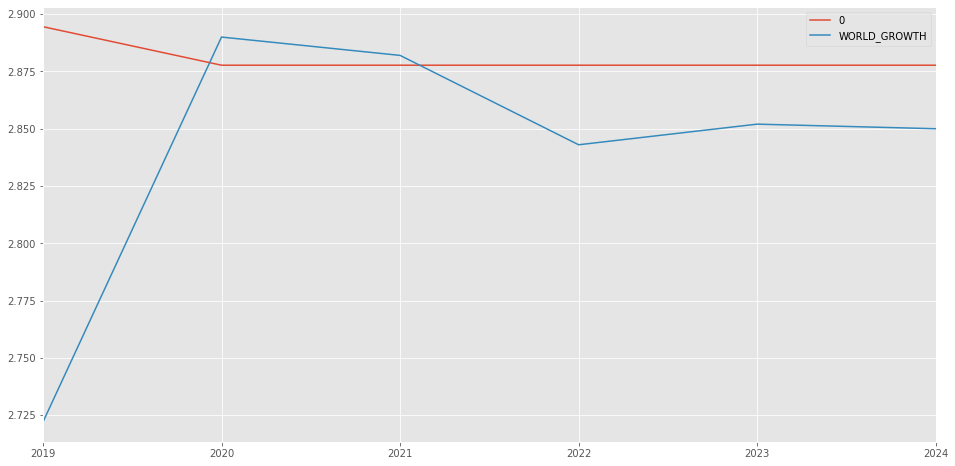

In [88]:
analyse_series(world_growth_train, world_growth_forecast, 0, 1, 2, 2014)

In [89]:
world_growth_forecast

YEAR
2019-01-01    2.722
2020-01-01    2.890
2021-01-01    2.882
2022-01-01    2.843
2023-01-01    2.852
2024-01-01    2.850
Name: WORLD_GROWTH, dtype: float64

***
***